**Dataset**\
Each row in the dataset is anonymized real policy data. A policy is considered churned if the difference between the start and end date is less than 1 year.

**Problem**\
Develop a model to predict a policy's probability to churn at time of sale.

In [31]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

In [58]:
import os
import pandas as pd

df = pd.read_csv(os.getcwd() + '/churn_data.csv', parse_dates=['start_date','end_date'])

ndays = ((df.end_date - df.start_date)).astype(int) / 1e9 / 60 / 60 / 24
df['churn'] = (ndays > 365).astype(int)

df.head()

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,churn
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment,0
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,0
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,0
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,0
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,1


In [59]:
df['nchan']=df['channel'].astype('category').cat.codes
df['ngeo']=df['geo'].astype('category').cat.codes
df.head()


,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,churn,nchan,ngeo
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment,0,1,42
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,0,6,34
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,0,7,9
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,0,7,34
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,1,7,20


In [55]:
df.isna().sum()

customer_id                0
start_date                 0
end_date                   0
years_of_experience        0
channel                   66
geo                        0
profession_id              0
cancellation_reason    19116
nchan                      0
ngeo                       0
dtype: int64

In [3]:
df.dtypes

customer_id                    object
start_date             datetime64[ns]
end_date               datetime64[ns]
years_of_experience           float64
channel                        object
geo                            object
profession_id                   int64
cancellation_reason            object
dtype: object

In [86]:
unique_ids = pd.Series(df.customer_id.unique())
unique_ids

0        d18013b0edd9a43a0fdb67c8cfbc3342
1        9f618809d3a625ddd81ce0d8237c99dd
2        47e9c803736f0999430324aaaba6046c
3        825463b772f05057975b61988718e6af
4        66a8c47b8ecaaed6fc1031b1d9ab1e3c
                       ...               
29656    946fccfb338a23416131ff24ac468230
29657    f4d071f7e0da61833cb50acb28bf64ca
29658    4034b58937d0d3ac0c53ab857e5aa371
29659    07f8603a41d6917691686b4e06060949
29660    dfbdfffe00aad24bf8b177c67e9dbc68
Length: 29661, dtype: object

In [83]:
n_train = int(df.customer_id.nunique() * 0.8)
train_ids = unique_ids.sample(n_train)
train = df.query(f'customer_id in {train_ids.to_list()}')
display(train.head())

valid_test = df.query(f'customer_id not in {train_ids.to_list()}')
n_valid = int(valid_test.customer_id.nunique() * 0.5)
valid_ids = valid_test.customer_id.sample(n_valid)
valid = valid_test.query(f'customer_id in {valid_ids.to_list()}')
test = valid_test.query(f'customer_id not in {valid_ids.to_list()}')

train.shape, valid.shape, test.shape

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,churn,nchan,ngeo
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,0,6,34
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,0,7,9
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,0,7,34
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,1,7,20
5,5ee75848b7158fb5db677259a882787e,2020-01-13,2021-01-13,5.0,sem,PA,5010,NaN,1,7,37


((23839, 11), (3083, 11), (3078, 11))

In [65]:
df.cancellation_reason.value_counts()

cancellation_reason
Non-Payment                                                                 4882
Insured is no longer in business                                            2001
I had a short-term need for insurance that has ended                        1470
Other reason (describe in notes)                                             389
I need coverage you can't provide                                            352
Insured found better coverage elsewhere at same price                        346
I don't see the value of having insurance anymore                            310
Waiver of subrogation                                                        298
Insured is covered by employer                                               174
Change operations/COB                                                        122
Unsigned terms and conditions                                                 99
Change business structure to/from Individual                                  96
Carrier 

In [63]:
feat_cols = ['nchan','ngeo', 'profession_id', 'years_of_experience']
X_train = train[feat_cols]
y_train = train.churn

X_valid = valid[feat_cols]
y_valid = valid.churn

X_test = test[feat_cols]
y_test = test.churn

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.6834743005855562

In [70]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_valid, rf.predict_proba(X_valid)[:,1])

In [74]:
results = pd.DataFrame({'precision':precision, 'recall':recall, 'thres':thresholds})
results

ValueError: All arrays must be of the same length

In [76]:
precision.shape

(1735,)

In [81]:
recall

array([1.        , 0.98239824, 0.98239824, ..., 0.00770077, 0.00550055,
       0.        ])

In [79]:
thresholds.shape

(1734,)

In [80]:
thresholds

array([0.00000000e+00, 6.89655172e-04, 7.31707317e-04, ...,
       9.93500000e-01, 9.97000000e-01, 1.00000000e+00])

In [39]:
df.profession_id.value_counts()

profession_id
100001    6680
5006      5789
5005      3385
5010      2604
5003      1955
5013      1102
100003    1052
100002    1049
100042     860
5007       785
5008       636
100019     508
5012       492
5009       448
5011       423
100005     249
100043     241
5014       232
100008     202
100004     184
100006     171
100041     169
100040     148
100045     124
100009     123
111653      98
111642      66
111643      57
111648      35
111654      29
111644      21
111646      19
111649      13
111641      12
111652       9
111645       7
100007       6
110753       5
110610       5
110756       4
111651       2
111656       1
Name: count, dtype: int64

In [28]:
df.channel.value_counts()

channel
sem              16853
agents            4434
organic           3173
social            1921
channel sales     1277
direct             792
display            512
support            392
video              391
email              153
unknown             31
native               5
Name: count, dtype: int64

(0.0, 75.0)

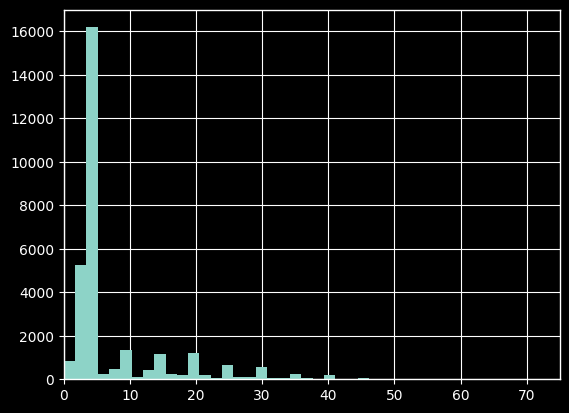

In [37]:
df.years_of_experience.hist(bins=100)
plt.xlim(0,75)

In [33]:
df.describe()

,start_date,end_date,years_of_experience,profession_id,churn
count,30000,30000,30000.000000,30000.000000,30000.000000
mean,2019-07-29 17:35:25.440000,2020-05-04 10:28:24.959999744,7.906867,43627.378333,0.286033
min,2018-01-17 00:00:00,2018-02-26 00:00:00,0.000000,5003.000000,0.000000
25%,2019-01-19 00:00:00,2019-09-28 00:00:00,5.000000,5006.000000,0.000000
50%,2019-08-22 00:00:00,2020-05-06 00:00:00,5.000000,5010.000000,0.000000
75%,2020-02-14 00:00:00,2021-01-07 00:00:00,7.000000,100001.000000,1.000000
max,2020-10-02 00:00:00,2021-10-02 00:00:00,171.000000,111656.000000,1.000000
std,NaN,NaN,8.038504,46832.667790,0.451913


In [34]:
df.years_of_experience.nlargest(10)

26363    171.0
4971      75.0
29487     65.0
13863     55.0
23860     55.0
18328     54.0
14021     52.0
531       50.0
668       50.0
923       50.0
Name: years_of_experience, dtype: float64

In [41]:
df.churn.value_counts() / df.shape[0]

churn
0    0.713967
1    0.286033
Name: count, dtype: float64